<a href="https://colab.research.google.com/github/thulieblack/deeplearnings/blob/main/Movielens_collab_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [2]:
from fastai.tabular.all import *
from fastai.collab import *

In [3]:
path = untar_data(URLs.ML_100k)

In [4]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [5]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


We build a DataLoaders object from the table above. By default, it takes the first column for user, the second column for the item (movies) and the third column for the ratings.Change the value of item_name to titles:



In [7]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [8]:
dls.show_batch()


,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


Create and train a collaborative filtering model by using collab_learner:

In [9]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))


In [10]:
learn.summary()

EmbeddingDotBias (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 50             
Embedding                                 47200      True      
Embedding                                 83250      True      
____________________________________________________________________________
                     64 x 1              
Embedding                                 944        True      
Embedding                                 1665       True      
____________________________________________________________________________

Total params: 133,059
Total trainable params: 133,059
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fb569ae3d40>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=3.0199516913853586e-05)

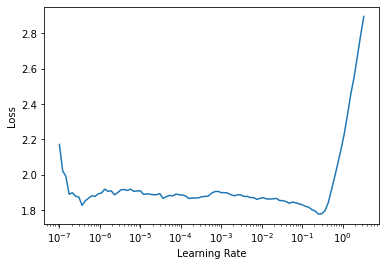

In [13]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(5, lr_min, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.084752,1.160442,00:11
1,1.121318,1.140951,00:11
2,0.973502,0.996621,00:11
3,0.796850,0.865299,00:11
4,0.518308,0.850531,00:11


# Interpretation

In [17]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:15]


array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)', 'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)', 'Raiders of the Lost Ark (1981)', 'Godfather, The (1972)', 'Pulp Fiction (1994)', 'Twelve Monkeys (1995)',
       'Silence of the Lambs, The (1991)'], dtype=object)

# Movie bias

In [18]:
movie_bias = learn.model.bias(top_movies, is_item=True)


In [19]:
movie_bias.shape

torch.Size([1000])

In [20]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [21]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:10]


[(tensor(-0.5409),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.4229),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.4085), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.4010), 'Grease 2 (1982)', 2.0),
 (tensor(-0.3569), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.3466), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.3448), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.3439), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.3432), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.3383), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407)]

In [22]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:10]

[(tensor(0.7253), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.7182), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.7097), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.6864), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.6847), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.6767), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.6659), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.6626), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.6622), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.6595), 'Usual Suspects, The (1995)', 4.385767790262173)]

In [23]:
movie_w = learn.model.weight(top_movies, is_item=True)


In [24]:
movie_w.shape


torch.Size([1000, 50])

In [25]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [26]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [28]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0493), 'Chinatown (1974)'),
 (tensor(-1.0415),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-1.0323), 'Godfather, The (1972)'),
 (tensor(-0.9964), 'Big Night (1996)'),
 (tensor(-0.9879), 'Casablanca (1942)'),
 (tensor(-0.9849), 'Fargo (1996)'),
 (tensor(-0.9606), 'Close Shave, A (1995)'),
 (tensor(-0.9030), 'When We Were Kings (1996)'),
 (tensor(-0.9025), 'Citizen Kane (1941)'),
 (tensor(-0.8975), 'Raging Bull (1980)')]

In [27]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1106), 'Jungle2Jungle (1997)'),
 (tensor(0.9871), 'Congo (1995)'),
 (tensor(0.9573), 'Kull the Conqueror (1997)'),
 (tensor(0.9498), 'Home Alone 3 (1997)'),
 (tensor(0.9381), 'Shadow Conspiracy (1997)'),
 (tensor(0.9365), "Dante's Peak (1997)"),
 (tensor(0.8915), 'Batman & Robin (1997)'),
 (tensor(0.8516), 'Father of the Bride Part II (1995)'),
 (tensor(0.8516), 'Turbulence (1997)'),
 (tensor(0.8262), 'Batman Forever (1995)')]

In [29]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [30]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1610), 'Braveheart (1995)'),
 (tensor(-1.1445), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9920), 'Forrest Gump (1994)'),
 (tensor(-0.9650), "It's a Wonderful Life (1946)"),
 (tensor(-0.9636), 'Field of Dreams (1989)'),
 (tensor(-0.9353), 'Fugitive, The (1993)'),
 (tensor(-0.9170), 'Shawshank Redemption, The (1994)'),
 (tensor(-0.9108), 'Titanic (1997)'),
 (tensor(-0.9056), 'American President, The (1995)'),
 (tensor(-0.8577), 'Independence Day (ID4) (1996)')]

In [31]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8449), 'Brazil (1985)'),
 (tensor(0.7511), 'Career Girls (1997)'),
 (tensor(0.7507), 'Trainspotting (1996)'),
 (tensor(0.7125), 'Crumb (1994)'),
 (tensor(0.7028), 'Half Baked (1998)'),
 (tensor(0.6666), 'Booty Call (1997)'),
 (tensor(0.6528), 'Boogie Nights (1997)'),
 (tensor(0.6325), 'Money Talks (1997)'),
 (tensor(0.6246), 'Stupids, The (1996)'),
 (tensor(0.6239), 'I Shot Andy Warhol (1996)')]

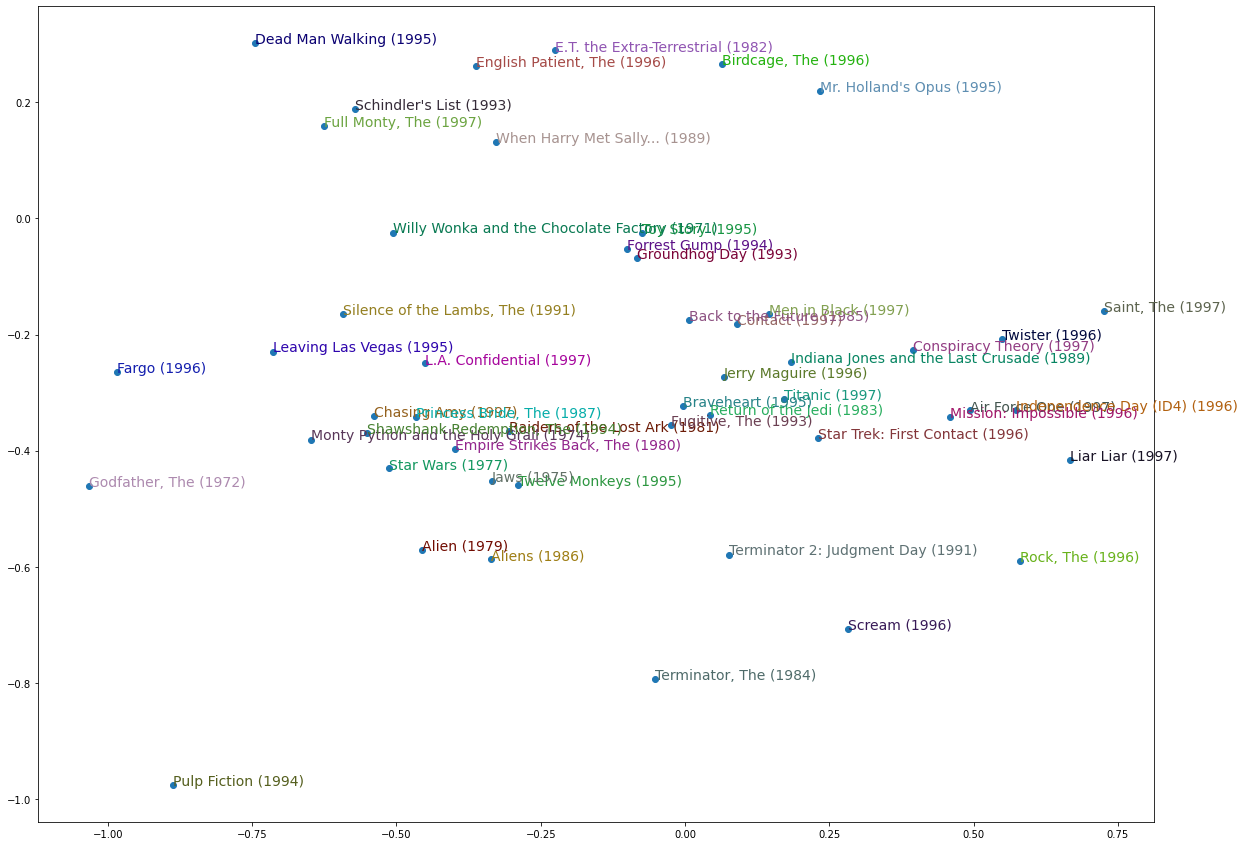

In [34]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(20,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=14)
plt.show()